**Welcome to this Notebook!**

UCLouvain - EPL - made by Justin Weeamels & Baptiste Sambon - 2023

*Step by step you will discover how we implemented and simulated a dowlink communication using the Code Divison Multiple Access method.*

*At first, let's import some packages like numpy, tensorflow, matplotlib, scipy and more importantly sionna and our home-made utils.py file. As said in the README, run this file twice!*

In [7]:
import numpy as np
try:
    import sionna
except ImportError as e:
    import os
    os.system("py -m pip install sionna")
    import sionna
import tensorflow as tf
import utils
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.linalg import hadamard
import random

*This is the initialization of the needed parameters as a dictionay named tx_params. Because we are in a perfect CSI case, these informations will be sent from the BS to the UE as a pilot before any communication.*

In [8]:
tx_params = {
    "nUsers" : 3,               # The number of UE.
    "powerAllocation_dB" : 0,   # The power allocated to the communication at the BS in dB.
    "nMessage" : 6,             # The number of bits representing the message to send.
    "nCodeCDMA" : 32,           # The number of bits used for the Walsh-Hadamard codes creation.
    "codes" : [],               # The array containing every created Walsh-Hadamard codes.
    "nGold" : 1024              # The number of bits used for the Gold codes creation.
}

*In order for you to compare with metrics you already know, we plotted here the BER/SNR curves of both the CDMA method and a basic case with an AWGN channel.*

In [9]:
# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1)
nb_seq = 1000
alpha = 0
ber = np.zeros(len(ebn0))

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

for i in range(len(ebn0)):

    # Noise variance and ber_i is an array used to compute the final BER mean value for each SNR.
    var_noise = 1/(10**(0.1*ebn0[i]))
    ber_i = np.zeros(nb_seq)

    # Loop on a lot of cases where the communication is reinitialized each time.
    # Each time, a new channel, a new code, new interferences, a new noise are created.
    for j in range(nb_seq):

        # Array containing the random messages for each UE.
        # These messages are encoded following the CDMA method.
        # These -1/+1 messages can now be sent through the channel from the BS to the UE.
        data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
        encoded = utils.CDMA_encode(data, tx_params)

        # This small series of code lines will simulate random data sent by other cells by received by our UE.
        # IT will be used with the Gold codes to represent the ICI.
        signalOtherCells = np.zeros(encoded.shape[0])
        for k in range(encoded.shape[0]):
            signalOtherCells[k] = random.randint(0, 1)
        signalOtherCells = utils.Binary2PlusMinusOne(signalOtherCells, int)

        # Creating a Rayleigh fading channel and random complex noise.
        h = utils.Rayleigh_canal(alpha, len(encoded))
        n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
             + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
        
        # The received signal expression will thus be the following line.
        # A sum of the encoded data passing through the channel, some random noise and some random interferences.
        # We represent the Gold code action by cancelling the ICI thanks to the crosscorrelation coefficients.
        received = encoded*h + n + signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]

        # At the UE, the received data is equalized using MMSE and then decoded with CDMA.
        var_symbols = np.var(encoded)
        var_channel = np.var(h)
        beta = (h*var_symbols**2)/((h**2*var_symbols**2)+(var_channel**2*var_symbols**2)+(var_noise**2))
        mmse = received*beta
        decoded = utils.CDMA_decode(mmse, tx_params)

        # Here we use tensorflow and sionna functions to compute the BER metric of the latter decoded signal.
        decoded_tf = tf.convert_to_tensor(decoded)
        decoded_tf = tf.cast(tf.less(0.0, decoded_tf), tf.float32)
        BinarySource = tf.cast(tf.less(0.0, data), tf.float32)
        ber_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf)
        ber_i[j] = ber_j.numpy()
        
    # Compute the final BER mean value for a specific SNR.
    ber[i] = np.mean(ber_i)

    # A nice print to see the BER result for each Eb/N0 value.
    print("Eb/N0 = " + str(ebn0[i]) + ", " + " "*(i<10) + "BER = " + f"{ber[i]:.9f}")

Eb/N0 = 0,  BER = 0.203833333
Eb/N0 = 1,  BER = 0.205500000
Eb/N0 = 2,  BER = 0.199555556
Eb/N0 = 3,  BER = 0.196166667
Eb/N0 = 4,  BER = 0.198000000


KeyboardInterrupt: 

*Now that this important metric has been computed for several Eb/N0 values, we can plot them nicely.*

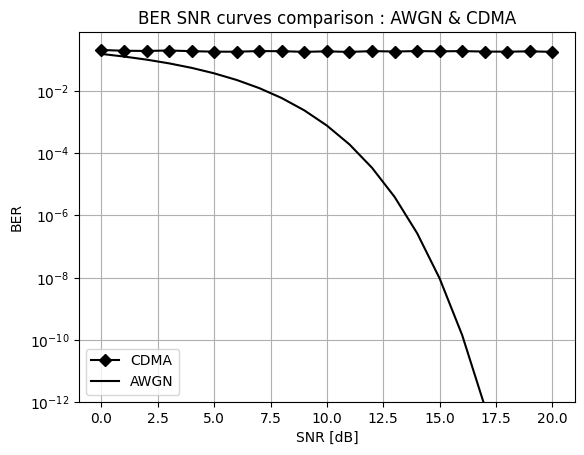

In [ ]:
ber_awgn = (1/2)*erfc(np.sqrt(10**(0.1*ebn0)/2))

plt.figure()
plt.semilogy(ebn0, ber, "D-", label="CDMA", color="black")
plt.plot(ebn0, ber_awgn, label="AWGN", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.ylim([10**(-12), 0.8])
plt.title("BER SNR curves comparison : AWGN & CDMA")
plt.savefig("CDMA-images/MyBERSNR.png")
plt.show()

*Let's discover the variability of the CDMA method in function of its main parameters. We will begin this kind of dependancy analysis with varying the number of UE in the scenario.*

In [ ]:
# Varying the number of UE in the scenario.
UserEquipements = [2, 4, 8, 16]

# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1)
nb_seq = 1000
alpha = 0
ber = np.zeros(len(ebn0))

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

# Creating the environment for the futur plots.
plt.figure()
symbols = ["D-", "o-", "s-", "^-"]

for user in range(len(UserEquipements)):

    # Setting up the current number of UE in the tx_params dictionary.
    tx_params["nMessage"] = UserEquipements[user]

    for i in range(len(ebn0)):

        # Noise variance and ber_i is an array used to compute the final BER mean value for each SNR.
        var_noise = 1/(10**(0.1*ebn0[i]))
        ber_i = np.zeros(nb_seq)

        # Loop on a lot of cases where the communication is reinitialized each time.
        # Each time, a new channel, a new code, new interferences, a new noise are created.
        for j in range(nb_seq):

            # Array containing the random messages for each UE.
            # These messages are encoded following the CDMA method.
            # These -1/+1 messages can now be sent through the channel from the BS to the UE.
            data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
            encoded = utils.CDMA_encode(data, tx_params)

            # This small series of code lines will simulate random data sent by other cells by received by our UE.
            # IT will be used with the Gold codes to represent the ICI.
            signalOtherCells = np.zeros(encoded.shape[0])
            for k in range(encoded.shape[0]):
                signalOtherCells[k] = random.randint(0, 1)
            signalOtherCells = utils.Binary2PlusMinusOne(signalOtherCells, int)

            # Creating a Rayleigh fading channel and random complex noise.
            h = utils.Rayleigh_canal(alpha, len(encoded))
            n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
                + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
            
            # The received signal expression will thus be the following line.
            # A sum of the encoded data passing through the channel, some random noise and some random interferences.
            # We represent the Gold code action by cancelling the ICI thanks to the crosscorrelation coefficients.
            received = encoded*h + n + signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]

            # At the UE, the received data is equalized using MMSE and then decoded with CDMA.
            var_symbols = np.var(encoded)
            var_channel = np.var(h)
            beta = (h*var_symbols**2)/((h**2*var_symbols**2)+(var_channel**2*var_symbols**2)+(var_noise**2))
            mmse = received*beta
            decoded = utils.CDMA_decode(mmse, tx_params)

            # Here we use tensorflow and sionna functions to compute the BER metric of the latter decoded signal.
            decoded_tf = tf.convert_to_tensor(decoded)
            decoded_tf = tf.cast(tf.less(0.0, decoded_tf), tf.float32)
            BinarySource = tf.cast(tf.less(0.0, BinarySource), tf.float32)
            ber_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf)
            ber_i[j] = ber_j.numpy()
            
        # Compute the final BER mean value for a specific SNR.
        ber[i] = np.mean(ber_i)

    # A nice plot of the corresponding BER/SNR curve for the current UE.
    plt.semilogy(ebn0, ber, symbols[user], label="CDMA-"+str(UserEquipements[user])+"_users", color="black")

TypeError: size() missing 1 required positional argument: 'a'

<Figure size 640x480 with 0 Axes>

*Each plots are now computed, so let's jump into the resulting figure.*

In [ ]:
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
# plt.ylim([10**(-12), 0.8])
plt.title("BER SNR curves comparison : UE's quantity dependancy")
plt.savefig("CDMA-images/MyBERSNRuser.png")
plt.show()

# Reset of the initial UE number.
tx_params["nUsers"] = 3

*Let's investigate if the length of the actual message sent by the BS will change the BER metric significantly.*

In [ ]:
# Varying the number of bits in the message in the scenario.
message = [8, 32, 64, 128]

# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1)
nb_seq = 1000
alpha = 0
ber = np.zeros(len(ebn0))

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

# Creating the environment for the futur plots.
plt.figure()
symbols = ["D-", "o-", "s-", "^-"]

for mes in range(len(message)):

    # Setting up the current message length in the tx_params dictionary.
    tx_params["nMessage"] = message[mes]

    for i in range(len(ebn0)):

        # Noise variance and ber_i is an array used to compute the final BER mean value for each SNR.
        var_noise = 1/(10**(0.1*ebn0[i]))
        ber_i = np.zeros(nb_seq)

        # Loop on a lot of cases where the communication is reinitialized each time.
        # Each time, a new channel, a new code, new interferences, a new noise are created.
        for j in range(nb_seq):

            # Array containing the random messages for each UE.
            # These messages are encoded following the CDMA method.
            # These -1/+1 messages can now be sent through the channel from the BS to the UE.
            data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
            encoded = utils.CDMA_encode(data, tx_params)

            # This small series of code lines will simulate random data sent by other cells by received by our UE.
            # IT will be used with the Gold codes to represent the ICI.
            signalOtherCells = np.zeros(encoded.shape[0])
            for k in range(encoded.shape[0]):
                signalOtherCells[k] = random.randint(0, 1)
            signalOtherCells = utils.Binary2PlusMinusOne(signalOtherCells, int)

            # Creating a Rayleigh fading channel and random complex noise.
            h = utils.Rayleigh_canal(alpha, len(encoded))
            n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
                + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
            
            # The received signal expression will thus be the following line.
            # A sum of the encoded data passing through the channel, some random noise and some random interferences.
            # We represent the Gold code action by cancelling the ICI thanks to the crosscorrelation coefficients.
            received = encoded*h + n + signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]

            # At the UE, the received data is equalized using MMSE and then decoded with CDMA.
            var_symbols = np.var(encoded)
            var_channel = np.var(h)
            beta = (h*var_symbols**2)/((h**2*var_symbols**2)+(var_channel**2*var_symbols**2)+(var_noise**2))
            mmse = received*beta
            decoded = utils.CDMA_decode(mmse, tx_params)

            # Here we use tensorflow and sionna functions to compute the BER metric of the latter decoded signal.
            decoded_tf = tf.convert_to_tensor(decoded)
            decoded_tf = tf.cast(tf.less(0.0, decoded_tf), tf.float32)
            BinarySource = tf.cast(tf.less(0.0, BinarySource), tf.float32)
            ber_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf)
            ber_i[j] = ber_j.numpy()
            
        # Compute the final BER mean value for a specific SNR.
        ber[i] = np.mean(ber_i)

    # A nice plot of the corresponding BER/SNR curve for the current message's length.
    plt.semilogy(ebn0, ber, symbols[mes], label="CDMA-"+str(message[mes])+"_message's_bits", color="black")

*No time to waste, what are the results?*

In [ ]:
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.title("BER SNR curve comparison : message's length dependancy")
plt.savefig("CDMA-images/MyBERSNRmessage.png")
plt.show()

# Reset of the initial message's number of bits.
tx_params["nMessage"] = 6

*Another metric to investigate on is the spectral efficiency of the CDMA method. To do so, as done before, we will iterate on a lot of communications and compute the mean of the capacity for a large number of SNR values.*

In [ ]:
# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the spectral efficiency.
ebn0 = np.arange(0, 21, 1)
nb_seq = tx_params["nMessage"]*tx_params["nCodeCDMA"]
alpha = 0
spectral_efficiency = np.zeros(len(ebn0))
p_power = 1

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

for i in range(len(ebn0)):

    # Noise variance and spectral_efficiency_i is an array used to compute the final spectral efficiency mean value for each SNR.
    var_noise = 1/(10**(0.1*ebn0[i]))
    spectral_efficiency_i = np.zeros(nb_seq)

    # Loop on a lot of cases where the communication is reinitialized each time.
    # Each time, a new channel, a new code, new interferences, a new noise are created.
    for j in range(nb_seq):

        # Array containing the random messages for each UE.
        # These messages are encoded following the CDMA method.
        # These -1/+1 messages can now be sent through the channel from the BS to the UE.
        data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
        encoded = utils.CDMA_encode(data, tx_params)

        # This small series of code lines will simulate random data sent by other cells by received by our UE.
        # IT will be used with the Gold codes to represent the ICI.
        signalOtherCells = np.zeros(encoded.shape[0])
        for k in range(encoded.shape[0]):
            signalOtherCells[k] = random.randint(0, 1)
        signalOtherCells = utils.Binary2PlusMinusOne(signalOtherCells, int)

        # Creating a Rayleigh fading channel and random complex noise.
        h = utils.Rayleigh_canal(alpha, len(encoded))
        n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
             + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
        
        # Compute the spectral efficiency by using the allocated power and the channel coefficients.
        # But also using the noise and interference values.        i_interference = signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]
        i_interference = signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]
        spectral_efficiency_i[j] = np.log2(1+(p_power*abs(h[j])**2)/(n[j]+i_interference[j]))
    
    # Compute the final spectral efficiency mean value for a specific SNR.
    spectral_efficiency[i] = np.mean(spectral_efficiency_i)

    # A nice print to see the spectral efficiency result for each Eb/N0 value.
    print("Eb/N0 = " + str(ebn0[i]) + ", " + " "*(i<10) + "Spectral efficiency = " + f"{spectral_efficiency[i]:.9f}")

*Let's discover what this new metric has to tell us about CDMA.*

In [ ]:
plt.figure()
plt.plot(ebn0, spectral_efficiency, "D-", label="CDMA-Spectral_efficiency", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("Spectral Efficiency [bits/sec/Hz]")
plt.xscale("linear")
# plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.title("Spectral efficiency curve of the used CDMA method")
plt.savefig("CDMA-images/Myspectralefficiency.png")
plt.show()

*Something else up to here?*